In [2]:
import time
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data_utils
import matplotlib.pyplot as plt

from matplotlib.pyplot import figure
from sklearn.model_selection import train_test_split


def get_crime_data(env_partition):
  attrib = pd.read_csv('attributes.csv', delim_whitespace = True)
  crime = pd.read_csv('communities.data', names = attrib['attributes'])
  crime = crime.drop(columns=['state','county','community','communityname','fold'], axis=1)
  crime = crime.replace('?', np.nan)
  crime['OtherPerCap'] = crime['OtherPerCap'].fillna(crime['OtherPerCap'].astype(float).mean())
  crime = crime.dropna(axis=1)
  crime['OtherPerCap'] = crime['OtherPerCap'].astype(float)
  crime['e_dummy'] = (crime['racepctblack'] > env_partition).astype(int)
  E = crime['e_dummy'] 
  y = crime['ViolentCrimesPerPop']
  crime = crime.drop(['racepctblack','ViolentCrimesPerPop','e_dummy'], axis=1)
  train_features, test_features, E_train, E_test, y_train, y_test = train_test_split(crime, E, y, test_size=0.2, random_state = 0)
  return train_features, test_features, E_train, E_test, y_train, y_test


def get_data_loaded(train_features, y_train, E_train):
  train_tensor = data_utils.TensorDataset(torch.Tensor(train_features.values), torch.Tensor(y_train.values).flatten(), torch.Tensor(E_train.values))
  train_loader = data_utils.DataLoader(train_tensor, batch_size=50, shuffle=True)
  return train_tensor, train_loader
  

def get_mse_coverage(mse_df):
	mse_cov = []
	cov = []
	samples_cov = []
	for count, datapoint in enumerate(mse_df.index):
		samples_cov.append(datapoint)
		mse_cov.append(np.sum(mse_df['mse'][samples_cov])/len(samples_cov))
		cov.append((count+1)/mse_df.shape[0])

	mse_cov_new = []
	cov_new = []
	for i in range(len(cov)):
		if cov[i] > 0.1:
			cov_new.append(cov[i])
			mse_cov_new.append(mse_cov[i])

	return mse_cov_new, cov_new


def AUC(x,y):
	area = 0
	for i in range(len(x)-1):
		area += np.abs((x[i+1]-x[i]))*y[i]
	return area

In [3]:
class Featurizer(nn.Module):
  def __init__(self, input_size, hiden_size=5):
    super(Featurizer, self).__init__()
    self.first = nn.Linear(input_size, hiden_size)
  

  def forward(self, x):
    out = F.selu(self.first(x))
    return out


class RegressorGroup(nn.Module):
  def __init__(self, output_size, hiden_size, num_domains, activation = False):
    super(RegressorGroup, self).__init__()
    self.last = []
    self.activation = activation
    for i in range(num_domains):
      self.last.append(nn.Linear(hiden_size, output_size))

    self.last = nn.ModuleList(self.last)
  
  
  def forward(self, x, d):
    if self.activation:
      out = F.softplus(self.last[d](x))
    else:
      out = self.last[d](x)
    return out


class RegressorJoint(nn.Module):
  def __init__(self, output_size, hiden_size, activation = False):
    super(RegressorJoint, self).__init__()
    self.last = nn.Linear(hiden_size, output_size)
    self.activation = activation
    
    
  def forward(self, x):
    if self.activation:
      out = F.softplus(self.last(x))
    else:
      out = self.last(x)
    return out

In [4]:
def partition (list_in, num_domains):
  np.random.shuffle(list_in)
  return [list_in[i::num_domains] for i in range(num_domains)]

def sufficiency(train_tensor, train_loader, args):
  training_loss = []
  input_size = train_tensor.tensors[0].size(1)
  output_size = 1
  num_domains = 2

  learning_rate = args['learning_rate']
  hidden_size = args['hidden_size']
  num_epochs = args['num_epochs']
  batch_size = args['batch_size']
  lbda = args['lbda']
  activation = args['activation']

  featurizer = Featurizer(input_size,hidden_size)
  regressorJoint = RegressorJoint(output_size,hidden_size, activation)
  regressorGroup = RegressorGroup(output_size, hidden_size, num_domains, activation)
  modelJoint = nn.Sequential(featurizer, regressorJoint)
  modelGroup = nn.Sequential(featurizer, regressorGroup)

  criterion = nn.MSELoss()
  optimizer_featurizer = torch.optim.Adam(featurizer.parameters(), lr=learning_rate, weight_decay=0)
  scheduler_featurizer = torch.optim.lr_scheduler.StepLR(optimizer_featurizer, step_size=2, gamma=0.5)
  optimizer_r_joint = torch.optim.Adam(regressorJoint.parameters(), lr=learning_rate, weight_decay=0)
  scheduler_r_joint = torch.optim.lr_scheduler.StepLR(optimizer_r_joint, step_size=2, gamma=0.5)
  optimizer_r_group = torch.optim.Adam(regressorGroup.parameters(), lr=learning_rate, weight_decay=0)
  scheduler_r_group = torch.optim.lr_scheduler.StepLR(optimizer_r_group, step_size=2, gamma=0.5)

  for epoch in range(num_epochs):
    t_loss = 0
    for i, (x, y, e) in enumerate(train_loader):
      y = y.reshape(-1, 1)
      features = featurizer(x)
      y_hat_joint = regressorJoint(features)
      joint_loss = criterion(y_hat_joint.reshape(-1, 1),y.reshape(-1, 1))

      #Compute group-specific loss
      group_specific_loss = 0
      for e_dummy in range(num_domains):
        y_domain = y[e == e_dummy]
        features_domain = features[e == e_dummy,:]
        y_hat_domain = regressorGroup(features_domain,e_dummy)
        group_specific_loss += criterion(y_hat_domain.reshape(-1, 1),y_domain.reshape(-1, 1))
                  
      #Compute group-agnostic loss
      indices = partition(np.arange(x.size(0)), num_domains)
      group_agnostic_loss = 0
      for e_dummy in range(num_domains):
        y_domain = y[indices[e_dummy]]
        features_domain = features[indices[e_dummy],:]
        y_hat_domain = regressorGroup(features_domain,e_dummy)
        group_agnostic_loss += criterion(y_hat_domain.reshape(-1, 1),y_domain.reshape(-1, 1))

      group_specific_loss_dummy = group_specific_loss.clone()
      loss = joint_loss - lbda*(group_specific_loss-group_agnostic_loss)
      loss_dummy = loss.clone() 

      optimizer_featurizer.zero_grad()
      loss_dummy.backward(retain_graph=True)
      optimizer_featurizer.step()

      optimizer_r_joint.zero_grad()
      loss_dummy.backward(retain_graph=True)
      optimizer_r_joint.step()

      optimizer_r_group.zero_grad()
      group_specific_loss_dummy.backward(retain_graph=True)
      optimizer_r_group.step()

      t_loss += loss

    scheduler_featurizer.step()
    scheduler_r_joint.step()
    scheduler_r_group.step()
    training_loss.append(t_loss/(i+1))

  return modelJoint, training_loss

In [5]:
def train_mean_network(train_features, E_train, y_train, args):
    train_tensor_mean, train_loader_mean = get_data_loaded(train_features, y_train, E_train)
    args['activation'] = False
    model_joint_mean, training_loss_mean = sufficiency(train_tensor_mean, train_loader_mean, args)
    return model_joint_mean, training_loss_mean

def train_var_network(train_features, E_train, y_train, args, model_joint_mean):
    train_tensor_mean, train_loader_mean = get_data_loaded(train_features, y_train, E_train)
    train_predicted_means = model_joint_mean(train_tensor_mean.tensors[0])
    y_train_var = torch.square(train_tensor_mean.tensors[1] - torch.squeeze(train_predicted_means))
    train_tensor_var, train_loader_var = get_data_loaded(pd.DataFrame(train_tensor_mean.tensors[0].detach().numpy()), pd.Series(y_train_var.detach().numpy()), pd.Series(train_tensor_mean.tensors[2].detach().numpy()))
    args['activation'] = True
    model_joint_var, training_loss_var = sufficiency(train_tensor_var, train_loader_var, args)
    
    return model_joint_var, training_loss_var

def test_network(test_features, E_test, y_test, model_joint_var, model_joint_mean):
    test_tensor_mean = data_utils.TensorDataset(torch.Tensor(test_features.values), torch.Tensor(y_test.values).flatten(), torch.Tensor(E_test.values))
    test_predicted_means = model_joint_mean(test_tensor_mean.tensors[0])
    y_test_var = torch.square(test_tensor_mean.tensors[1] - torch.squeeze(test_predicted_means))
    test_tensor_var = data_utils.TensorDataset(test_tensor_mean.tensors[0], torch.Tensor(pd.Series(y_test_var.detach().numpy()).values), test_tensor_mean.tensors[2])
    test_predicted_var = model_joint_var(test_tensor_var.tensors[0])

    mse = pd.DataFrame(y_test_var.detach().numpy(), columns=['mse'])
    mse['variance'] = torch.squeeze(test_predicted_var).detach().numpy()
    mse['e'] = E_test.to_numpy().reshape(-1,1)
    mse = mse.sort_values(['variance'], ascending=[True])
    return mse

In [6]:
env_partition = 0.2
train_features, test_features, E_train, E_test, y_train, y_test = get_crime_data(env_partition)

In [7]:
args_baseline = {'num_epochs':40,'batch_size':128,'learning_rate':5e-3,'hidden_size':50,'lbda':0.0}
residue_baseline_model_mean, _ = train_mean_network(train_features, E_train, y_train, args_baseline)
residue_baseline_model_var, _ = train_var_network(train_features, E_train, y_train, args_baseline, residue_baseline_model_mean)

residue_baseline_mse_df = test_network(test_features, E_test, y_test, residue_baseline_model_var, residue_baseline_model_mean)
residue_baseline_mse, residue_baseline_cov = get_mse_coverage(residue_baseline_mse_df)
residue_baseline_mse_0, residue_baseline_cov_0 = get_mse_coverage(residue_baseline_mse_df[residue_baseline_mse_df['e']==0])
residue_baseline_mse_1, residue_baseline_cov_1 = get_mse_coverage(residue_baseline_mse_df[residue_baseline_mse_df['e']==1])

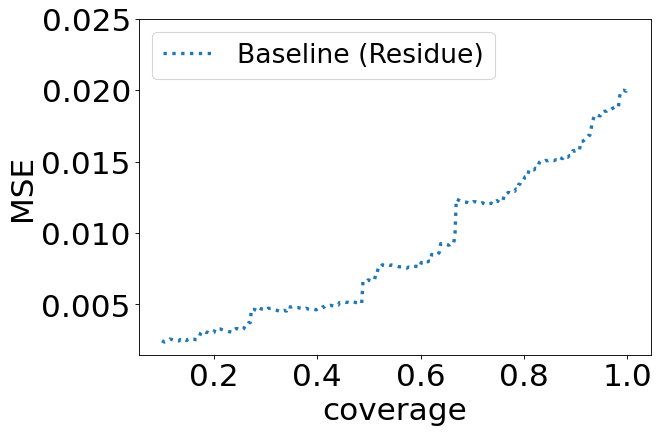

In [9]:
plt.figure(figsize=((8, 6)), dpi=80)
plt.axes((.18, .2, .80, .70))

line1 = plt.plot(residue_baseline_cov, residue_baseline_mse, ':', linewidth = 3.0, label = 'Baseline (Residue)')

ax = plt.gca()
ax.set_xlabel("coverage",fontsize = 28)
ax.set_ylabel("MSE",fontsize = 28)
plt.xticks(fontsize=28)
plt.yticks(fontsize=28)

ax.set_yticks([0.005,0.010,0.015,0.020,0.025], minor=False) 
handles, labels = ax.get_legend_handles_labels()
lgd = ax.legend(handles, labels, loc='upper left', fontsize=24)

plt.show()

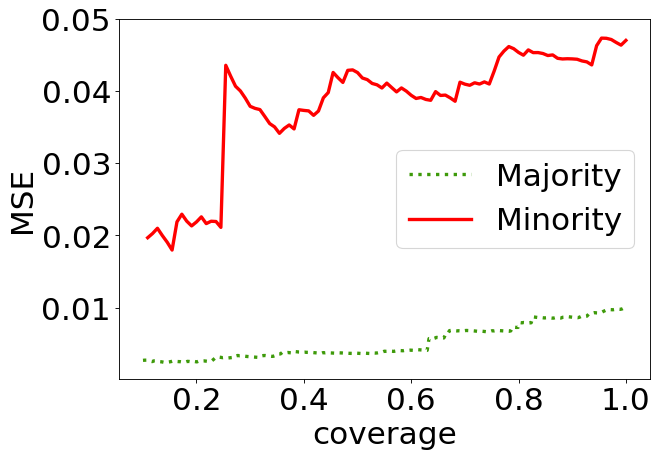

In [10]:
# Gaussian (one-stage) baseline
plt.figure(figsize=((8, 6)), dpi=80)
plt.axes((.165, .2, .83, .75))

line1 = plt.plot(residue_baseline_cov_0, residue_baseline_mse_0, ':', linewidth = 3.0, label = 'Majority', color = '#3E9A0A')
line2 = plt.plot(residue_baseline_cov_1, residue_baseline_mse_1, linewidth = 3.0, label = 'Minority', color = '#FF0000')

ax = plt.gca()
ax.set_xlabel("coverage",fontsize =28)
ax.set_ylabel("MSE",fontsize =28)
plt.xticks(fontsize=28)
plt.yticks(fontsize=28)

ax.set_yticks([0.01,0.02,0.03,0.04,0.05], minor=False) 
handles, labels = ax.get_legend_handles_labels()
lgd = ax.legend(handles, labels, loc='center right', fontsize=28)

plt.show()

In [11]:
args_calibration = {'num_epochs':40,'batch_size':128,'learning_rate':5e-3,'hidden_size':50,'lbda':1.0}
residue_calibration_model_mean, _ = train_mean_network(train_features, E_train, y_train, args_calibration)
residue_calibration_model_var, _ = train_var_network(train_features, E_train, y_train, args_calibration, residue_calibration_model_mean)

residue_calibration_mse_df = test_network(test_features, E_test, y_test, residue_calibration_model_var, residue_calibration_model_mean)
residue_calibration_mse, residue_calibration_cov = get_mse_coverage(residue_calibration_mse_df)
residue_calibration_mse_0, residue_calibration_cov_0 = get_mse_coverage(residue_calibration_mse_df[residue_calibration_mse_df['e']==0])
residue_calibration_mse_1, residue_calibration_cov_1 = get_mse_coverage(residue_calibration_mse_df[residue_calibration_mse_df['e']==1])

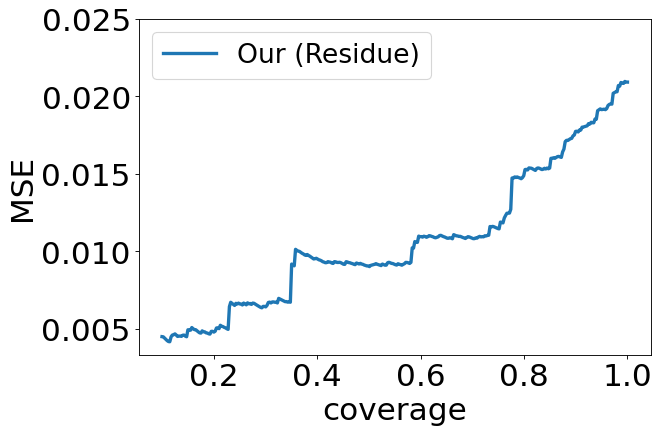

In [13]:
plt.figure(figsize=((8, 6)), dpi=80)
plt.axes((.18, .2, .80, .70))

line1 = plt.plot(residue_calibration_cov, residue_calibration_mse, linewidth = 3.0, label = 'Our (Residue)')	

ax = plt.gca()
ax.set_xlabel("coverage",fontsize = 28)
ax.set_ylabel("MSE",fontsize = 28)
plt.xticks(fontsize=28)
plt.yticks(fontsize=28)

ax.set_yticks([0.005,0.010,0.015,0.020,0.025], minor=False) 
handles, labels = ax.get_legend_handles_labels()
lgd = ax.legend(handles, labels, loc='upper left', fontsize=24)

plt.show()

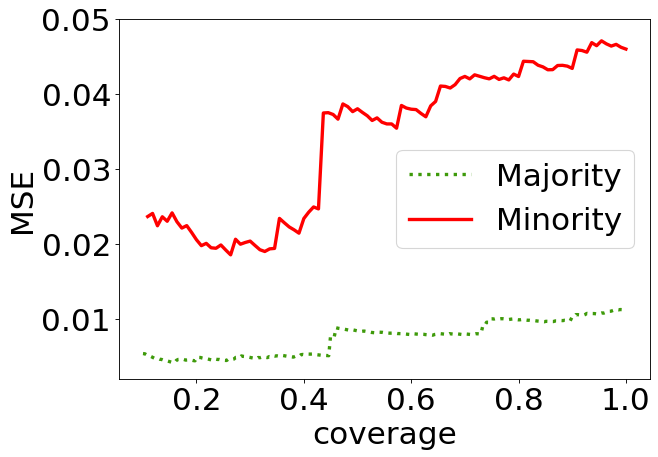

In [14]:
# Gaussian (one-stage) sufficiency
plt.figure(figsize=((8, 6)), dpi=80)
plt.axes((.165, .2, .83, .75))

line1 = plt.plot(residue_calibration_cov_0, residue_calibration_mse_0, ':', linewidth = 3.0, label = 'Majority', color = '#3E9A0A')
line2 = plt.plot(residue_calibration_cov_1, residue_calibration_mse_1, linewidth = 3.0, label = 'Minority', color = '#FF0000')

ax = plt.gca()
ax.set_xlabel("coverage",fontsize =28)
ax.set_ylabel("MSE",fontsize =28)
plt.xticks(fontsize=28)
plt.yticks(fontsize=28)

ax.set_yticks([0.01,0.02,0.03,0.04,0.05], minor=False) 
handles, labels = ax.get_legend_handles_labels()
lgd = ax.legend(handles, labels, loc='center right', fontsize=28)

plt.show()